### Файлы модели
https://drive.google.com/drive/folders/1IGaM7nOk6nQC_a19Ce6v3wy__g7CHDjK


## Необходимые библиотеки

* OpenCV - pip install opencv-python
* Matplotlib - pip install matplotlib
* NumPy - pip install numpy

## Используемые фотографии

### изначально черно белые
* https://unsplash.com/photos/rbPplWrpgcU
* https://unsplash.com/photos/oGSxaXK-dVw
* https://unsplash.com/photos/YE6iUShVcps
* https://unsplash.com/photos/5DJqsjAYlmk
* https://unsplash.com/photos/YE6iUShVcps

### изначально цветные
* https://pixabay.com/photos/flowers-lotus-petals-pond-8144828/
* https://pixabay.com/photos/spider-jumping-spider-arachnid-8158656/
* https://pixabay.com/photos/flower-dahlia-blossom-close-up-8200546/
* https://pixabay.com/photos/girls-children-tulips-red-tulips-739071/

In [1]:
# Импорт библиотек
import numpy as np
# отрисовка фотографий
import matplotlib.pyplot as plt
# работа с изображениями
import cv2
# создание градиентной карты cmap
from matplotlib.colors import LinearSegmentedColormap


In [2]:
# Путь у нашему тестовому изображению
image = 'image.jpg'

# Пути для caffemodel, prototxt, и numpy файлов

# Состоит из различных параметров, определяющих сеть, а также помогает в развертывании модели Caffe.
prototxt = "model/colorization_deploy_v2.prototxt"
# предварительно обученная модель, хранящаяся в формате платформы Caffe, которую можно использовать для прогнозирования новых невидимых данных
caffe_model = "model/colorization_release_v2.caffemodel"
# файл NumPy, в котором хранятся центральные точки кластера в формате NumPy. Он состоит из 313 ядер кластера.
pts_npy = "model/pts_in_hull.npy"

# Загрузка модели
net = cv2.dnn.readNetFromCaffe(prototxt, caffe_model)
pts = np.load(pts_npy)

# параметризация модели 
layer1 = net.getLayerId("class8_ab")
layer2 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)

net.getLayer(layer1).blobs = [pts.astype("float32")]
net.getLayer(layer2).blobs = [np.full([1, 313], 2.606, dtype="float32")]

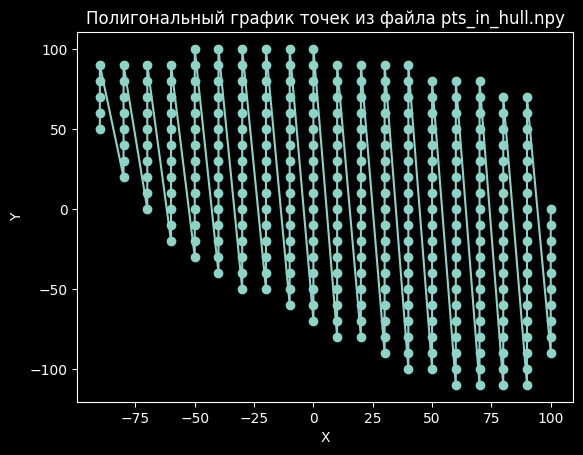

In [3]:
# содержимое pts файла, если люопытно
pts = np.load(pts_npy)
x = pts[:, 0]
y = pts[:, 1]


plt.plot(x, y, marker='o')  # Используем marker для обозначения точек
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Полигональный график точек из файла pts_in_hull.npy')
plt.show()

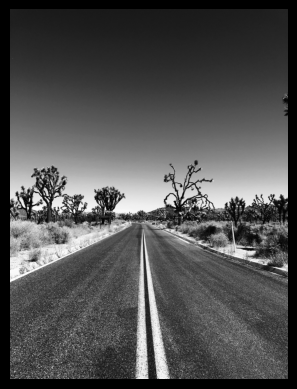

In [4]:
def image_reading(image):
    test_image = cv2.imread(image)
    # # Convert image into gray scale
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    # Convert image from gray scale to RGB format
    test_image = cv2.cvtColor(test_image, cv2.COLOR_GRAY2RGB)
    # Check image using matplotlib
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()
    return test_image

test_image = image_reading(image)

In [5]:

def l_layer_getting(test_image, X = 224, Y = 224, l_shift = 50):
    # Нормализуем изображение
    normalized = test_image.astype("float32") / 255.0
    # Конвертируем RGB в LAB формат
    lab_image = cv2.cvtColor(normalized, cv2.COLOR_RGB2LAB)
    resized = cv2.resize(lab_image, (X, Y))
    L = cv2.split(resized)[0]
    L -= l_shift
    return L , lab_image  
L, lab_image = l_layer_getting(test_image=test_image)

In [6]:
def color_predict(L, test_image):
    # Предсказываем a и b цветовые каналы
    # Передаем в модель L канал из LAB изображения
    net.setInput(cv2.dnn.blobFromImage(L))
    # Получаем 'a' и 'b'
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))
    # Изменяем размер назад к оригинальному
    ab = cv2.resize(ab, (test_image.shape[1], test_image.shape[0]))
    return ab
ab = color_predict(L, test_image)

In [7]:
# Создаем градиентные карты для графиков

# Для а канала (красно-зеленого)
color_a = [
    (0, 0.5, 0),    # Зеленый
    (1.0, 1.0, 1.0), # Белый
    (1, 0, 0),   # Красный
]
# Для b канала (сине-желтого)
color_b = [
    (0, 0, 1),    # Синий
    (1.0, 1.0, 1.0), # Белый
    (1, 1, 0),   # Желтый
]
cmap_a = LinearSegmentedColormap.from_list("CustomCmap", color_a)
cmap_b = LinearSegmentedColormap.from_list("CustomCmap", color_b)

color_maps = [cmap_a, cmap_b]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


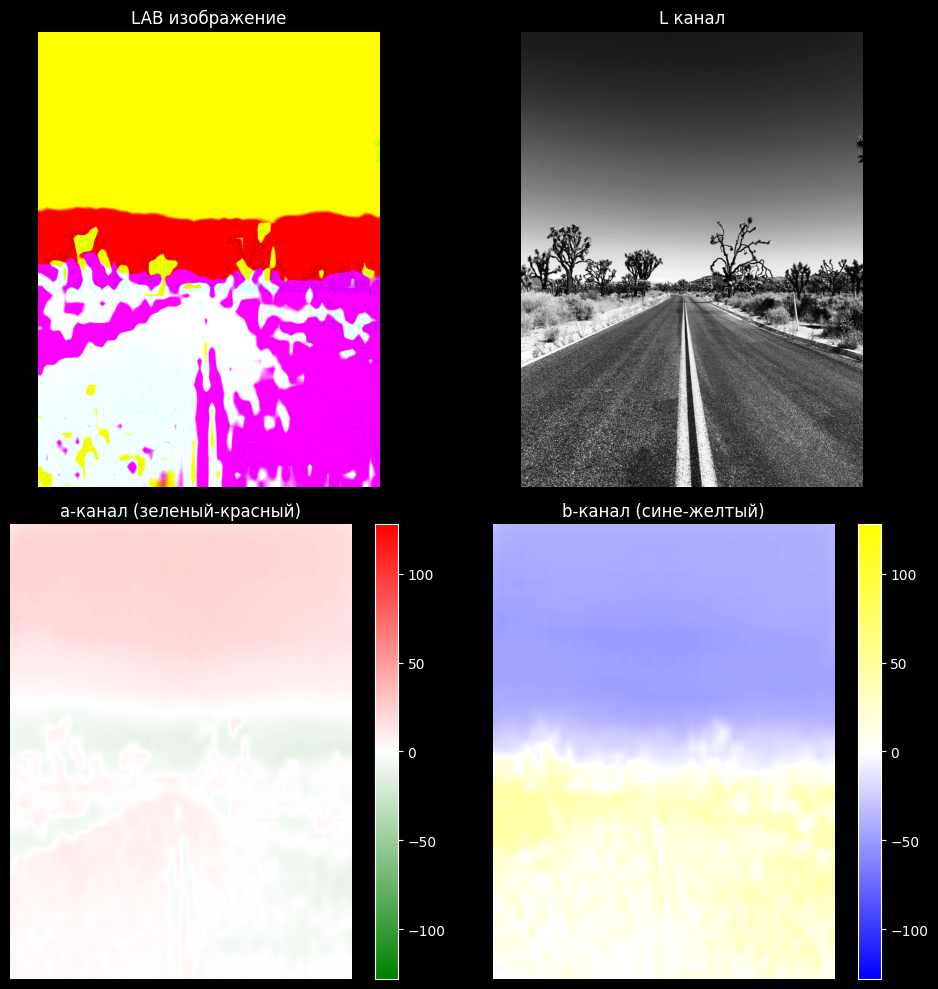

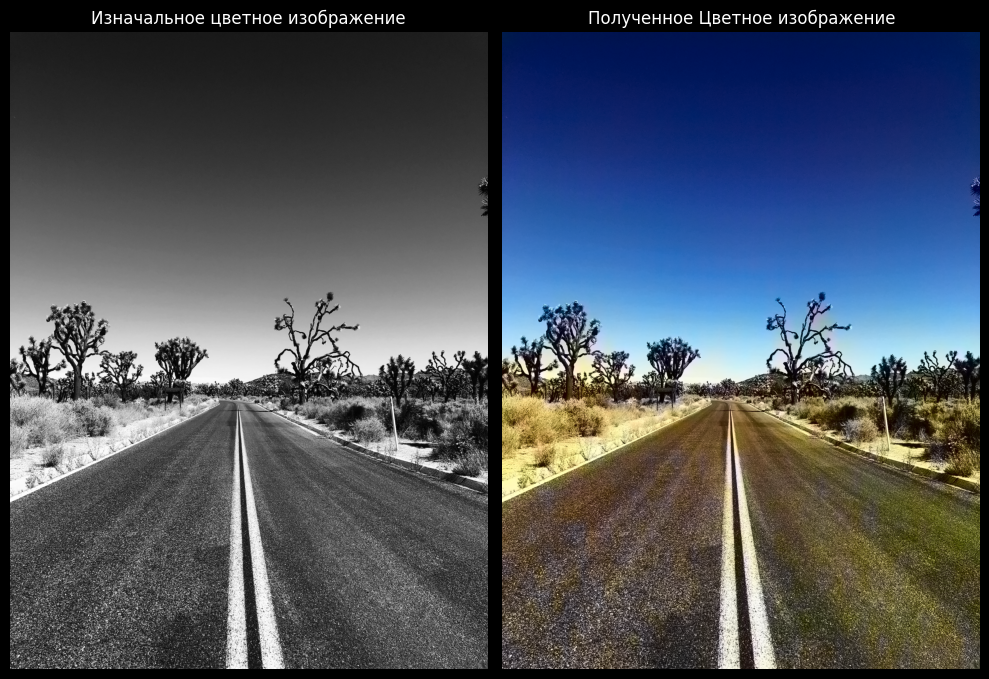

In [8]:

def graph_builder(lab_image, ab, path, color_maps, test_image):

    # Выделяем отдельно L Из LAB
    L = cv2.split(lab_image)[0]
    # Комбинируем L, a и b каналы вместе, для получения цветной картинки в LAB формате, где a и b это предсказанные цвета, а L изначальная картинка в LAB формате и ее L слой
    LAB_colored = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    # создаем график для отрисовки промежуточных шагов
    plt.figure(figsize=(10, 10))

    # график с сеткой 2 x 2
    plt.subplot(2, 2, 1)
    plt.imshow(LAB_colored)
    plt.axis('off')
    plt.title('LAB изображение')

    plt.subplot(2, 2, 2)
    plt.imshow(LAB_colored[:,:,0], cmap = 'gray')
    plt.axis('off')
    plt.title('L канал')

    plt.subplot(2, 2, 3)
    plt.imshow(LAB_colored[:,:,1],cmap=color_maps[0], vmin=-128, vmax=128)
    plt.axis('off')
    plt.title('a-канал (зеленый-красный)')
    plt.colorbar()

    plt.subplot(2, 2, 4)
    plt.imshow(LAB_colored[:,:,2],cmap=color_maps[1], vmin=-128, vmax=128)
    plt.axis('off')
    plt.title('b-канал (сине-желтый)')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


    # создаем график для отрисовки начального файла и результата
    plt.figure(figsize = (10,10))

    plt.subplot(1,2,1)
    plt.imshow(test_image)
    plt.title('Изначальное цветное изображение')
    plt.axis('off')

    plt.subplot(1,2,2)
    ## корнвертируем LAB в RGB
    RGB_colored = cv2.cvtColor(LAB_colored,cv2.COLOR_LAB2RGB)
    # Проверяем/обрезаем что выскочила за диапазон 0..1
    RGB_colored = np.clip(RGB_colored, 0, 1)
    # Возвращаем контрасность
    RGB_colored = (255 * RGB_colored).astype("uint8")

    plt.title('Полученное Цветное изображение')
    plt.imshow(RGB_colored)
    plt.axis('off')


    plt.tight_layout()
    plt.show()

    # Корнвертируем RGB to BGR
    RGB_BGR = cv2.cvtColor(RGB_colored, cv2.COLOR_RGB2BGR)
    # Сохраняем цветное изображение
    cv2.imwrite("output_images/"+path, RGB_BGR)
    
graph_builder(lab_image, ab, image, color_maps, test_image)    

    # 1 - ый
    # resized = cv2.resize(lab_image, (224*8, 224*8))
    # 2 - ой
    # resized = cv2.resize(lab_image, (224, 112))
    # 3 - ий
    # resized = cv2.resize(lab_image, (224*2, 224*2))
    # 4 - ый L - 60
    # resized = cv2.resize(lab_image, (224 * 16, 224 * 16 ))
    # 5 - ый 
    # resized = cv2.resize(lab_image, (224, 224))
    # 6 - ой
    # resized = cv2.resize(lab_image, (112, 112))
    # 7 - ой
    # resized = cv2.resize(lab_image, (224, 224))
    # 8 - ый  L -40
    # resized = cv2.resize(lab_image, (224, 224))
    # 9 - ый  L -55
    # resized = cv2.resize(lab_image, (224 * 6, 224 * 4))
    

In [9]:
def gray_to_color(path, color_maps, X = 224, Y = 224, l_shift = 50):
    # черно белое изображение
    test_image = image_reading(path)
    # получаем L слой
    L, lab_image = l_layer_getting(test_image=test_image, X=X, Y=Y, l_shift=l_shift)
    # предсказываем a b слои
    ab = color_predict(L, test_image)
    # отрисовываем
    graph_builder(lab_image, ab, path, color_maps, test_image)

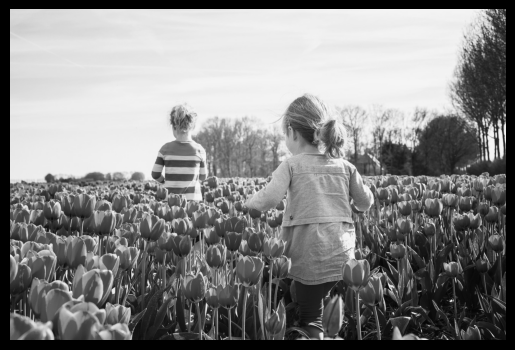

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


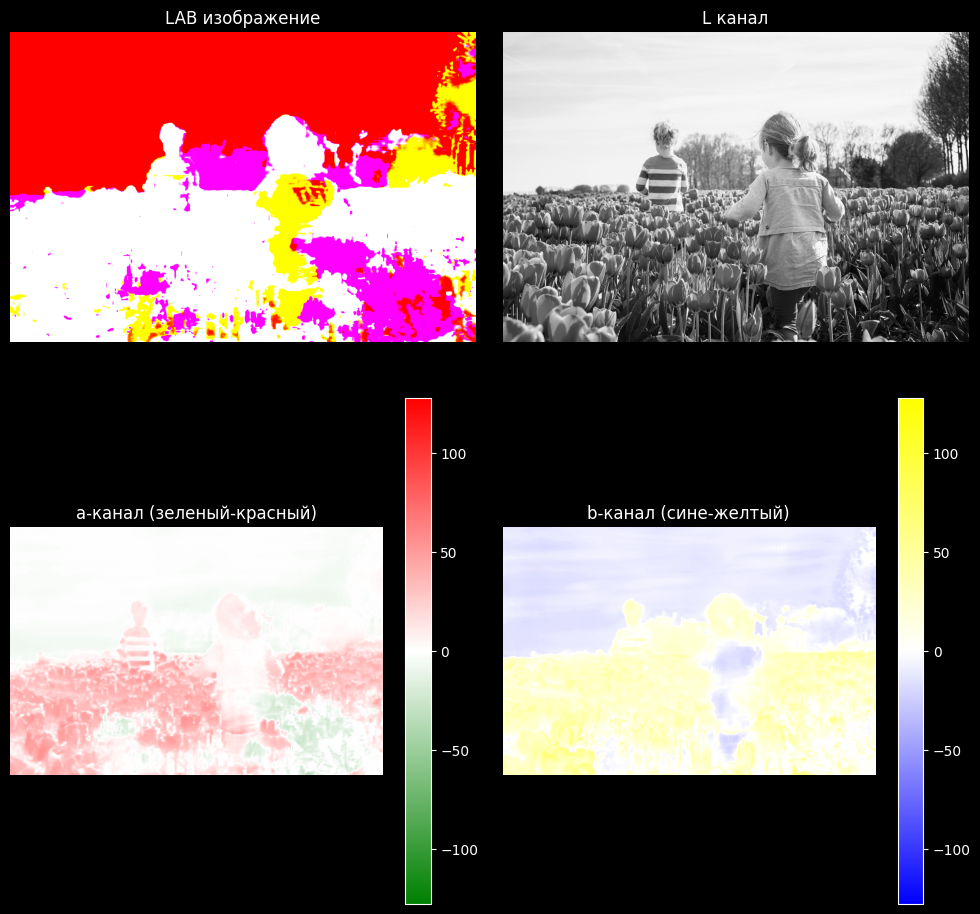

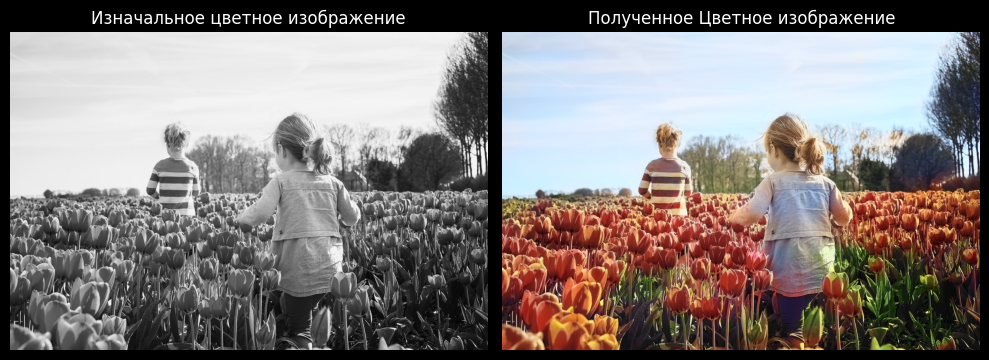

In [30]:
gray_to_color('image_9.jpg',color_maps, 224*4, 224*4, 55)

In [ ]:
gray_to_color('image_4.jpg',color_maps, 224, 224)